# Homework 2

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.

#### a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?

#### b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

#### a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.

#### b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

#### c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)

#### d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?

## 4. The HDG Product

#### a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

#### b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

#### c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Aug 2023`.

In [2]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
from scipy.stats import kurtosis, skew
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [4]:
_DATA_DIR = r'C:\Users\Neil2\Desktop\mpp/FINM port\data'
file_path = f'{_DATA_DIR}/proshares_analysis_data.xlsx'
hf_data = pd.read_excel(file_path, sheet_name = 'hedge_fund_series', index_col = 0)
hf_data.index.name = 'date'
hf_data.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.0321,-0.0256,-0.0257,-0.0270,-0.0065
2011-09-30,-0.0389,-0.0324,-0.0326,-0.0325,-0.0221
2011-10-31,0.0269,0.0436,0.0433,0.0505,0.0252
2011-11-30,-0.0135,-0.0121,-0.0124,-0.0286,-0.0080
2011-12-31,-0.0045,0.0019,0.0018,0.0129,0.0018


In [5]:
merrill = pd.read_excel(file_path,sheet_name = 'merrill_factors', index_col = 0)
merrill.index.name = 'date'
merrill.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,
2011-08-31,-0.0550,0.0000,-0.0925,-0.0875,-0.0059,-0.0889
2011-09-30,-0.0694,0.0000,-0.1791,-0.1081,0.1422,-0.1115
2011-10-31,0.1091,-0.0000,0.1630,0.0963,-0.0695,0.1510
2011-11-30,-0.0041,0.0000,-0.0197,-0.0218,0.0546,-0.0038
2011-12-31,0.0104,0.0000,-0.0426,-0.0217,0.0756,0.0051


In [6]:
other_data = pd.read_excel(file_path,sheet_name = 'other_data', index_col = 0)
other_data.index.name = 'date'
other_data.head()

,TRVCI Index,HEFA US Equity,TAIL US Equity,SPXU US Equity,UPRO US Equity
date,,,,,
2011-08-31,-0.0652,NaN,NaN,0.0565,-0.2109
2011-09-30,-0.0368,NaN,NaN,0.1900,-0.2070
2011-10-31,0.1000,NaN,NaN,-0.2988,0.3261
2011-11-30,-0.0358,NaN,NaN,-0.0355,-0.0336
2011-12-31,-0.0255,NaN,NaN,-0.0520,0.0230


## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [7]:
hf_data = hf_data.merge(merrill.loc[:,['SPY US Equity']], left_index = True, right_index = True)

In [8]:
summary_stats = performance_summary(hf_data)
summary_stats.loc[:,['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
HFRIFWI Index,0.0432,0.0602,0.7177
MLEIFCTR Index,0.0319,0.0570,0.5597
MLEIFCTX Index,0.0304,0.0568,0.5351
HDG US Equity,0.0205,0.0594,0.3455
QAI US Equity,0.0196,0.0501,0.3917
SPY US Equity,0.1332,0.1459,0.9129


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [9]:
summary_stats

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,5.9183,-0.0251,-0.0375,-0.1155,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,1.6643,-0.0287,-0.0359,-0.1243,2021-06-30,2022-09-30,NaT
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,1.6316,-0.0289,-0.0358,-0.1244,2021-06-30,2022-09-30,NaT
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,1.7801,-0.0312,-0.0376,-0.1407,2021-06-30,2022-09-30,NaT
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,1.7376,-0.0201,-0.0327,-0.1377,2021-06-30,2022-09-30,NaT
SPY US Equity,0.1332,0.1459,0.9129,-0.4112,0.7885,-0.0680,-0.0867,-0.2393,2021-12-31,2022-09-30,NaT


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [56]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6)
        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret.values-rf.values).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant: 
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error)

In [62]:
hedge_funds = hf_data.columns
factor = merrill['SPY US Equity']
rf = merrill['USGG3M Index']

df_lst= []
for fund in hedge_funds:
    fund_ret = hf_data[fund]
    reg = regression_based_performance(factor,fund_ret,rf)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [fund]))

reg_performance = pd.concat(df_lst)
reg_performance.iloc[5, 2] = -0.7992
reg_performance

,Market Beta,Treynor Ratio,Information Ratio,Alpha,R-Squared
HFRIFWI Index,0.3487,0.0970,-0.1005,-0.0003,0.7140
MLEIFCTR Index,0.3496,0.0644,-0.5803,-0.0012,0.8023
MLEIFCTX Index,0.3483,0.0603,-0.6316,-0.0013,0.8008
HDG US Equity,0.3594,0.0310,-0.9839,-0.0023,0.7805
QAI US Equity,0.2961,0.0345,-0.7844,-0.0017,0.7449
SPY US Equity,1.0000,0.1239,-0.7992,-0.0000,1.0000


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

*Statistics related to tail risks:*
1. Compared to SPY US Equity, all hedge funds have considerably higher Excess Kurtosis, which indicates heavy tails on the bell-shaped distribution curve, so the higher tail risk.

2. The above conclusion about tail risk is proved by VaR and CVar: SPY has lower tail risk than any other hedge fund.

3. Among all Hedge Funds Indexes and SPY, only HFRIFWI Index was able to recovery from drawdown

*Statistics based on Regression:*
1. All hedge funds are less volatile than SPY, because Market beta is less than 1. This is a result of asset diversification.
2. SPY has the largest Treynor Ratio among all hedge funds, so no hedge fund was able to surpass the market in terms of risk adjusted returns.
3. All hedge funds have negative Information ratio. It means that they fail to beat the market.

### Which performs better between HDG and QAI:

**Market beta**: HDG US Equity has a higher market beta than QAI US Equity, so HDG US Equity is more volotile compared to QAI US Equity. As a confirmation, we additionally calculated RSquared, which shows that high portion of variance is explained by the regression.

**Treynor Ratio**: HDG US Equity has a smaller TR than QAI US Equity. That means QAI US Equity has higher risk adjusted returns. The result is expected, because:
$$
TR = \frac{\mathbb{E}(\tilde{r})}{\beta}
$$
So the higher market beta is, the lower risk adjusted returns are.

**Information Ratio**: because of negative Alpha, both HDG US Equity and QAI US Equity has negative IR. But since QAI has a less negative alpha, QAI has a better Information Ratio.

As a result, QAI shows better risk-adjusted returns

### Whether HDG and the ML series capture the most notable properties of HFRI.
1. Both HDG and the ML series show almost same market betas, which means that they have almost same market risks as HFRI.

2. However, HFRI has sufficiently higher Treynor Ratio than HDG and the ML series, which represents that they underperformed in terms of risk adjusted returns compared to HFRI

3. HDG and the ML series underperforms in terms of Information Ratio, which indicates returns unexplained by the market.

As a result, HDG, MLEIFCTR, MLEIFCTX do not capture the most notable properties of HFRI.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

In [13]:
asset_corr = hf_data.corr()

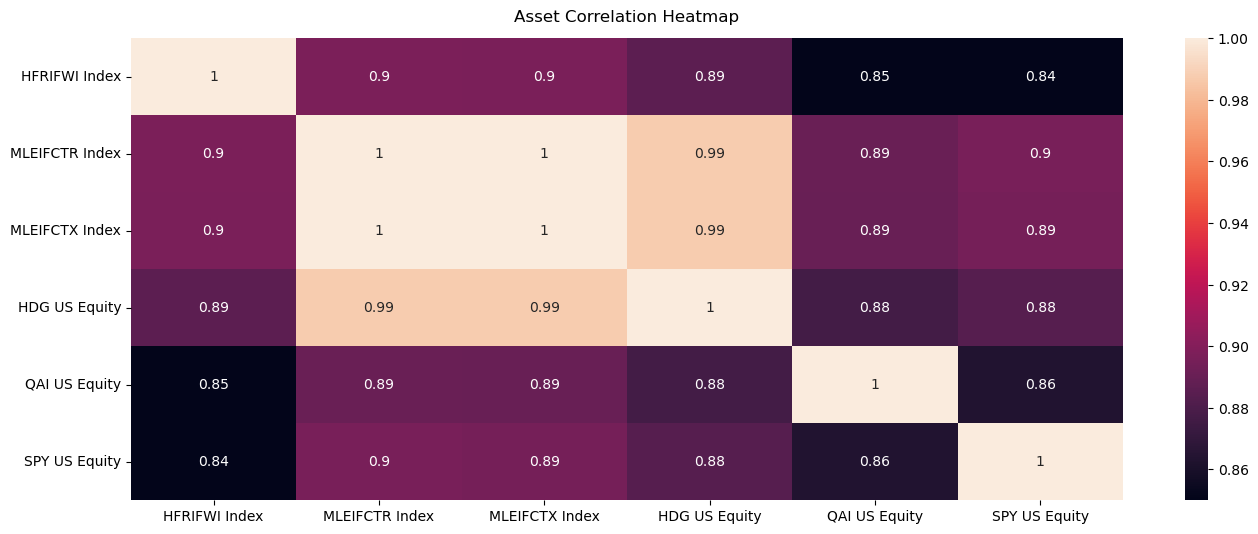

In [14]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(asset_corr, vmin=0.85, vmax=1, annot=True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [15]:
sorted_corr.nlargest(3,'Correlations')

,,Correlations
MLEIFCTX Index,MLEIFCTR Index,0.9999
MLEIFCTR Index,MLEIFCTX Index,0.9999
HDG US Equity,MLEIFCTR Index,0.9873


In [16]:
sorted_corr.nsmallest(1, 'Correlations')

,,Correlations
HFRIFWI Index,SPY US Equity,0.8450


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

#### a. Report the intercept and betas.
#### b. Are the betas realistic position sizes, or do they require huge long-short positions?
#### c. Report the R-squared.
#### d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [31]:
hedge_funds = hf_data.columns
factor = merrill
rf = merrill['USGG3M Index']

df1_lst= []
pred = []
for fund in hedge_funds:
    fund_ret = hf_data[fund]
    reg = regression_based_performance(factor,fund_ret,rf)
    beta = dict(reg[0])
    beta.update(Intercept = float(reg[3]))
    beta.update(RSquared = float(reg[4]))
    beta.update(TrackingError = float(reg[5]))
    df1_lst.append(pd.DataFrame([beta],index = [fund]))


    one_df = pd.DataFrame(np.ones(fund_ret.shape[0])).T
    one_df.columns = factor.index
    factor_ret = pd.concat([factor.T,one_df])
    reg_param = pd.DataFrame([beta]).loc[:,['SPY US Equity','USGG3M Index','EEM US Equity','EFA US Equity','EUO US Equity','IWM US Equity','Intercept']]
    pred.append(pd.DataFrame(np.array(reg_param) @ np.array(factor_ret),columns = factor.index, index = [fund]))

hedge_replication = pd.concat(df1_lst)
hedge_replication.loc[['HFRIFWI Index']] 

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.0333,-0.1659,0.0779,0.0824,0.0226,0.1521,0.0014,0.8369,0.0243


### Are the betas realistic position sizes, or do they require huge long-short positions?

- In general, all the betas take realistic values. There is one relatively big short in USGG3M Index and one relatively big long in IWM US Equity.
- The betas are realistic position sizes except USGG3M Index (which is negative and indicates a short position) as they do not require huge short positions. USGG3M Index explains that most of risk HFRI can be explained from 3 month treasury yield.


### Performance Stats of Predicted Returns from Above Regression

In [32]:
hedge_replication_pred = pd.concat(pred)
hedge_replication_performance = performance_summary(hedge_replication_pred.T)
hedge_replication_performance

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.0432,0.0551,0.7845,-0.4646,1.7822,-0.0247,-0.0331,-0.0912,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,0.0319,0.0552,0.5776,-0.4542,1.7526,-0.0265,-0.0343,-0.0940,2019-12-31,2020-03-31,2020-11-30
MLEIFCTX Index,0.0304,0.0550,0.5524,-0.4535,1.7456,-0.0265,-0.0343,-0.0940,2019-12-31,2020-03-31,2020-11-30
HDG US Equity,0.0205,0.0567,0.3618,-0.4520,1.7527,-0.0284,-0.0362,-0.1047,2021-06-30,2022-09-30,NaT
QAI US Equity,0.0196,0.0455,0.4305,-0.3828,1.0406,-0.0229,-0.0288,-0.0866,2021-08-31,2022-09-30,2023-07-31
SPY US Equity,0.1332,0.1459,0.9129,-0.4112,0.7885,-0.0680,-0.0867,-0.2393,2021-12-31,2022-09-30,NaT


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

From below we see the OOS regression (rolling return) replication actually fits the actual returns pretty well:

- Average return is 0.0387 for fitted value compared to 0.0540 in actual values, while the actual values has higher vol. Thus, while actual in-sample returns does provide a higher sharp ratio, it is not too much different from the replication.
- Fitted values and actual returns have very high correlation (0.9388)
- A relatively lower negative skewness and lower excess Kurtosis for fitted returns also points out to a good fit by the rolling regression model

In [35]:
def rolling_regression_param(factor,fund_ret,roll_window = 60):
    """ 
        Returns the Rolling Regression parameters for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            roll_window = rolling window for regression
        Output:
            params - Dataframe with time-t as the index and constant and Betas as columns
    """
    X = sm.add_constant(factor)
    y= fund_ret
    rols = RollingOLS(y, X, window=roll_window)
    rres = rols.fit()
    params = rres.params.copy()
    params.index = np.arange(1, params.shape[0] + 1)
    return params

In [44]:
df2_lst= []
for fund in hedge_funds:
    fund_ret = pd.DataFrame(hf_data[fund].copy())
    rolling_reg = rolling_regression_param(merrill,fund_ret)
    factor_ret = merrill.iloc[rolling_reg.dropna().index.min():]
    one_df = pd.DataFrame(np.ones(factor_ret.shape[0])).T
    one_df.columns = factor_ret.index
    factor_ret = pd.concat([one_df,pd.DataFrame(factor_ret).T])
    df2_lst.append(pd.DataFrame(np.diag(pd.DataFrame(np.array(rolling_reg[60:]) @ np.array(factor_ret))), index = factor_ret.columns, columns = [fund]).T)
    
    
rolling_reg_replication = pd.concat(df2_lst)
rolling_reg_replication.T

rolling_reg_performance = performance_summary(rolling_reg_replication.T)
rolling_reg_performance.loc[['HFRIFWI Index']]

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.0387,0.0611,0.6339,-0.6680,2.6220,-0.0270,-0.0374,-0.0965,2019-12-31,2020-03-31,2020-08-31


In [46]:
actual_performance = performance_summary(hf_data[60:])
actual_performance.loc[['HFRIFWI Index']]

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.0540,0.0669,0.8063,-1.1155,6.6790,-0.0238,-0.0402,-0.1155,2019-12-31,2020-03-31,2020-08-31


Correlation of Rolling Regression Fitted Returns with Actual Returns- 0.9388822480077514


<Axes: xlabel='date'>

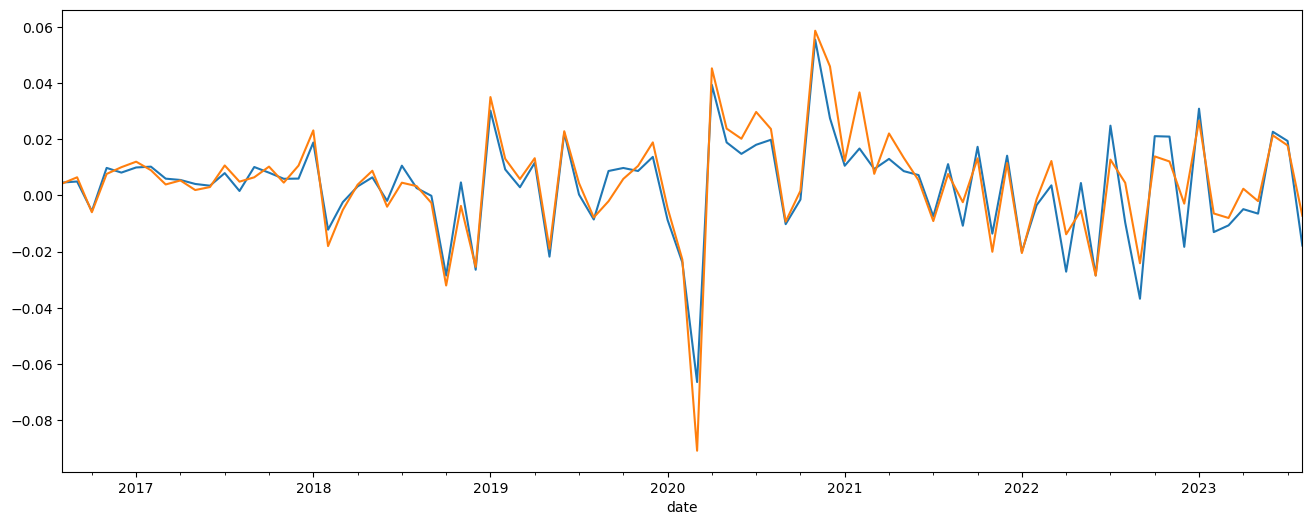

In [47]:
print('Correlation of Rolling Regression Fitted Returns with Actual Returns- ' + str(np.corrcoef(hf_data.iloc[rolling_reg.dropna().index.min():]['HFRIFWI Index'], rolling_reg_replication.T['HFRIFWI Index'])[0,1]))

plt.figure(figsize=(100, 6))
ax = rolling_reg_replication.T['HFRIFWI Index'].plot(figsize=(16, 6))
hf_data.iloc[rolling_reg.dropna().index.min():]['HFRIFWI Index'].plot(ax=ax);

In [51]:
df = pd.DataFrame({
    'Actual': hf_data.iloc[rolling_reg.dropna().index.min():]['HFRIFWI Index'],
    'Fitted': rolling_reg_replication.T['HFRIFWI Index']
})

correlation_matrix = df.corr()
correlation_value = correlation_matrix.loc['Actual', 'Fitted']
correlation_matrix
correlation_value

0.9388822480077519

### Conclusion:

1. The graph illustrates that dynamics of both original and replicated index are close to each other.

2. This result is confirmed by high positive correlation coefficient: 0.938

3. The fitted returns have lower annualized returns than original HFRI index. Even though the replicated returns have lower volatility than original HFRI index, the annualized Sharpe Ratio is larger for the original HFRI returns.

4. Another big diffirence is in Excess Kurtosis: the replicated returns have much lower Excess Kurtosis than the original returns

## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

Beta with intercept will be different from beta without intercept:
 
Dropping the intercept will make the slope of the fit steeper, thus beta will absorb loss of intercept and have significantly different values. For instance, the most significant change includes: 
 
   - SPY US Equity changed from 0.0333 to 0.0509 in market beta, in investing terms, this means that we are gaining more exposure to SPY US Equity.
   - USGG3M Index changed from -0.1659 to 0.3378 in market beta, this means that we went from borrowing to investing in USGG3M Index


In [39]:
hedge_funds = hf_data.columns
factor = merrill
rf = merrill['USGG3M Index']

df3_lst= []
for fund in hedge_funds:
    fund_ret = hf_data[fund]
    reg = regression_based_performance(factor,fund_ret,rf,constant=False)
    beta = dict(reg[0])
    beta.update(RSquared = float(reg[2]))
    beta.update(TrackingError = float(reg[3]))
    df3_lst.append(pd.DataFrame([beta],index = [fund]))
    
    
no_constant_replication = pd.concat(df3_lst)
no_constant_replication.loc[['HFRIFWI Index']]

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,RSquared,TrackingError
HFRIFWI Index,0.0509,0.3378,0.0776,0.0753,0.0256,0.1486,0.8399,0.0244


In [40]:
hedge_replication.loc[['HFRIFWI Index']]

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,Intercept,RSquared,TrackingError
HFRIFWI Index,0.0333,-0.1659,0.0779,0.0824,0.0226,0.1521,0.0014,0.8369,0.0243


The Mean fitted returns for the hedge fund series is quite different from the actual mean returns. For the HFRI index, the fitted returns are close to 99 basis points lesser than the actual returns. This is a result of deviating betas which absorbed the loss of the intercept in the regression. 

In [41]:
merrill_summary = performance_summary(merrill)
df4_lst = []
for fund in hf_data.columns:
    fit_ret = np.array(no_constant_replication[no_constant_replication.index == fund][merrill.columns]) @ np.array(merrill.T)
    #fit_ret = dict(fit_ret)
    df4_lst.append(pd.DataFrame(fit_ret.T,columns = [fund], index = [merrill.index] ).T)

fit_returns = pd.concat(df4_lst)
mean_fit_returns = performance_summary(fit_returns.T).rename(columns = {'Mean':'Mean Fitted Returns'})
mean_fit_returns = mean_fit_returns.loc[:,['Mean Fitted Returns']].merge(summary_stats.loc[:,['Mean']], on = mean_fit_returns.index).rename(columns={'key_0' : 'Hedge Fund','Mean':'Mean Actual Returns'}).set_index('Hedge Fund')
mean_fit_returns.loc[['HFRIFWI Index']]

,Mean Fitted Returns,Mean Actual Returns
Hedge Fund,,
HFRIFWI Index,0.0331,0.0432


Both fitted values $\check{r}^{\hfri}_{t}$ (without intercept) and  $\hat{r}^{\hfri}_{t}$ (with intercept) has very high correlations to HFRI. There is only a minor increase/improvement in correlation for $\hat{r}^{\hfri}_{t}$ that has a result of 0.9148. This slight increase in correlation when including an intercept suggests that the intercept term adds minimal explanatory power to the model for predicting HFRI returns.

In [42]:
no_constant_replication = np.corrcoef(hf_data['HFRIFWI Index'], fit_returns.T['HFRIFWI Index'])[0,1]
constant_replication = np.corrcoef(hf_data['HFRIFWI Index'], hedge_replication_pred.T['HFRIFWI Index'])[0,1]
pd.DataFrame([[no_constant_replication,constant_replication]],columns=['Without Intercept','With Intercept'],index = ['Fitted & Actual Return Correlation'])


,Without Intercept,With Intercept
Fitted & Actual Return Correlation,0.9140,0.9148


Merril and ProShares likely fit the replicators without an intercept, because of the following reasons:
1. Intercept will allow us to capture the alpha, which is the risk-adjusted return over and above what is explained by model's factors. This is useful if we are trying to replicate the hedge. With an intercept, the regression model does not force the factor loadings to account for the mean returns of the hedge fund index (HFRI).
2. However, if we want to use the mean returns to be fully explained by factors, where every aspect of portfolio's performance can be attributed directly by factors in the model, we will need to drop the intercept. This is useful to extrapolate what attributes the return and how investors can match the return in addition to variation.
3. Thus, since HDG's mean return is lower than HFRI, it could be the case that regression is run without an intercept. Beta in this case fully accounts for the factor weight one needs to allocate to each asset. 

In [52]:
summary_stats

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,0.0432,0.0602,0.7177,-0.9832,5.9183,-0.0251,-0.0375,-0.1155,2019-12-31,2020-03-31,2020-08-31
MLEIFCTR Index,0.0319,0.0570,0.5597,-0.2558,1.6643,-0.0287,-0.0359,-0.1243,2021-06-30,2022-09-30,NaT
MLEIFCTX Index,0.0304,0.0568,0.5351,-0.2418,1.6316,-0.0289,-0.0358,-0.1244,2021-06-30,2022-09-30,NaT
HDG US Equity,0.0205,0.0594,0.3455,-0.2440,1.7801,-0.0312,-0.0376,-0.1407,2021-06-30,2022-09-30,NaT
QAI US Equity,0.0196,0.0501,0.3917,-0.4584,1.7376,-0.0201,-0.0327,-0.1377,2021-06-30,2022-09-30,NaT
SPY US Equity,0.1332,0.1459,0.9129,-0.4112,0.7885,-0.0680,-0.0867,-0.2393,2021-12-31,2022-09-30,NaT


***

# 3.  Extensions
<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

***